In [1]:
# COMMON IMPORTS
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langchain.tools import tool
from langsmith import Client, wrappers
from pydantic import BaseModel, Field
from typing_extensions import Annotated
from langgraph.managed.is_last_step import RemainingSteps
from langchain_google_genai import ChatGoogleGenerativeAI
import os, re , ast, tempfile, subprocess, openai
from dotenv import load_dotenv
from langchain_core.messages import ( HumanMessage, SystemMessage, AIMessage, ToolMessage, AnyMessage)
from time import sleep
from langgraph.graph.message import add_messages 

import pandas as pd


load_dotenv()

/home/aidodo/Foundations_of_AgenticAI/agentic-labs/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


True

In [2]:
df = pd.read_csv('mbpp_san_train.csv', usecols=['task_id','prompt','code','test_list'])
df = df.iloc[0:20]
df.head(20)

,task_id,prompt,code,test_list
0,602,Write a python function to find the first repe...,"def first_repeated_char(str1):\n for index,c ...","['assert first_repeated_char(""abcabc"") == ""a""'..."
1,603,Write a function to get all lucid numbers smal...,def get_ludic(n):\n\tludics = []\n\tfor i in r...,"['assert get_ludic(10) == [1, 2, 3, 5, 7]'\n '..."
2,604,Write a function to reverse words seperated by...,def reverse_words(s):\n return ' '.join...,"['assert reverse_words(""python program"")==(""pr..."
3,605,Write a function to check if the given integer...,def prime_num(num):\n if num >=1:\n for i i...,['assert prime_num(13)==True' 'assert prime_nu...
4,606,Write a function to convert degrees to radians.,import math\ndef radian_degree(degree):\n radi...,['assert radian_degree(90)==1.5707963267948966...
5,607,Write a function to search a string for a rege...,"import re\n\ndef find_literals(text, pattern):...","[""assert find_literals('The quick brown fox ju..."
6,608,Write a python function to find nth bell number.,def bell_Number(n): \n bell = [[0 for i in ...,['assert bell_Number(2) == 2' 'assert bell_Num...
7,610,Write a python function which takes a list and...,"def remove_kth_element(list1, L):\n return ...","['assert remove_kth_element([1,1,2,3,4,4,5,1],..."
8,611,Write a function which given a matrix represen...,"def max_of_nth(test_list, N):\n res = max([su...","['assert max_of_nth([[5, 6, 7], [1, 3, 5], [8,..."
9,612,Write a python function which takes a list of ...,def merge(lst): \n return [list(ele) for e...,"[""assert merge([['x', 'y'], ['a', 'b'], ['m', ..."


In [3]:
def extract_function_names(code: str):
    """
    Return a list of function names found in `code`.
    - Top-level functions and async functions => 'name'
    - Class methods => 'ClassName.method'
    Falls back to a regex search if AST parsing fails.
    """
    if not isinstance(code, str) or not code.strip():
        return []
    names = []
    try:
        tree = ast.parse(code)
        for node in tree.body:
            if isinstance(node, (ast.FunctionDef, ast.AsyncFunctionDef)):
                names.append(node.name)
            elif isinstance(node, ast.ClassDef):
                for item in node.body:
                    if isinstance(item, (ast.FunctionDef, ast.AsyncFunctionDef)):
                        names.append(f"{node.name}.{item.name}")
        return names
    except SyntaxError:
        # fallback: find `def name(` or `async def name(` (simple)
        matches = re.findall(r'^\s*(?:async\s+)?def\s+([A-Za-z_][A-Za-z_0-9]*)\s*\(', code, flags=re.MULTILINE)
        return matches

# Example: apply to your dataframe `df` that has a 'code' column
df['function_names'] = df['code'].fillna('').apply(extract_function_names)
# first (primary) function name (or None)
df['function_name'] = df['function_names'].apply(lambda l: l[0] if l else None)

# Inspect results
print(df[['task_id','function_name']].head(30))

    task_id        function_name
0       602  first_repeated_char
1       603            get_ludic
2       604        reverse_words
3       605            prime_num
4       606        radian_degree
5       607        find_literals
6       608          bell_Number
7       610   remove_kth_element
8       611           max_of_nth
9       612                merge
10      614      cummulative_sum
11      615        average_tuple
12      616         tuple_modulo
13      617            min_Jumps
14      618             div_list
15      619             move_num
16      620       largest_subset
17      622           get_median
18      623             nth_nums
19      624             is_upper


In [4]:
df.drop(columns=['function_names'], inplace=True)
df.head(20)

,task_id,prompt,code,test_list,function_name
0,602,Write a python function to find the first repe...,"def first_repeated_char(str1):\n for index,c ...","['assert first_repeated_char(""abcabc"") == ""a""'...",first_repeated_char
1,603,Write a function to get all lucid numbers smal...,def get_ludic(n):\n\tludics = []\n\tfor i in r...,"['assert get_ludic(10) == [1, 2, 3, 5, 7]'\n '...",get_ludic
2,604,Write a function to reverse words seperated by...,def reverse_words(s):\n return ' '.join...,"['assert reverse_words(""python program"")==(""pr...",reverse_words
3,605,Write a function to check if the given integer...,def prime_num(num):\n if num >=1:\n for i i...,['assert prime_num(13)==True' 'assert prime_nu...,prime_num
4,606,Write a function to convert degrees to radians.,import math\ndef radian_degree(degree):\n radi...,['assert radian_degree(90)==1.5707963267948966...,radian_degree
5,607,Write a function to search a string for a rege...,"import re\n\ndef find_literals(text, pattern):...","[""assert find_literals('The quick brown fox ju...",find_literals
6,608,Write a python function to find nth bell number.,def bell_Number(n): \n bell = [[0 for i in ...,['assert bell_Number(2) == 2' 'assert bell_Num...,bell_Number
7,610,Write a python function which takes a list and...,"def remove_kth_element(list1, L):\n return ...","['assert remove_kth_element([1,1,2,3,4,4,5,1],...",remove_kth_element
8,611,Write a function which given a matrix represen...,"def max_of_nth(test_list, N):\n res = max([su...","['assert max_of_nth([[5, 6, 7], [1, 3, 5], [8,...",max_of_nth
9,612,Write a python function which takes a list of ...,def merge(lst): \n return [list(ele) for e...,"[""assert merge([['x', 'y'], ['a', 'b'], ['m', ...",merge


In [5]:
def extract_assert_statements(input_string):
    """
    Extract assert statements from a string representation of a list
    """
    if pd.isna(input_string) or input_string == '':
        return []
    
    try:
        # First pass normalization
        normalized = re.sub(r"'\s*\n\s*'", "', '", input_string)
        
        # Second pass: fix missing commas between adjacent quotes
        # This handles cases like "'assert1' 'assert2'" -> "'assert1', 'assert2'"
        normalized = re.sub(r"'(\s*)'", r"',\1'", normalized)
        
        #print(f"Normalized input: {normalized}")
        parsed = ast.parse(normalized, mode='eval')
        return [element.value for element in parsed.body.elts 
                if isinstance(element, ast.Constant) and isinstance(element.value, str)]
    except Exception as e:
        print(f"AST parsing failed: {e}")
        return extract_assert_statements_fallback(input_string)

def extract_assert_statements_fallback(input_string):
    """
    Robust fallback method that handles various formatting issues
    """
    # Remove outer brackets and quotes
    cleaned = input_string.strip().strip('[]')
    
    # Method 1: Split by the pattern that separates assert statements
    # This handles both comma-separated and space-separated cases
    statements = re.split(r"',\s*'|\'\s+\'", cleaned)
    
    # Clean each statement
    cleaned_statements = []
    for stmt in statements:
        stmt = stmt.strip().strip("'")
        if stmt and stmt.startswith('assert'):
            cleaned_statements.append(stmt)
    
    # Method 2: If the above doesn't capture enough, use direct pattern matching
    if len(cleaned_statements) < 2:  # If we didn't find enough statements
        statements = re.findall(r"assert [^']+", cleaned)
        cleaned_statements = [stmt.strip() for stmt in statements if stmt.strip()]
    
    return cleaned_statements

# Apply the extraction function
df['test_list_extracted'] = df['test_list'].apply(extract_assert_statements)

In [158]:
df[['function_name','test_list_extracted']].head(20)

,function_name,test_list_extracted
0,first_repeated_char,"[assert first_repeated_char(""abcabc"") == ""a"", ..."
1,get_ludic,"[assert get_ludic(10) == [1, 2, 3, 5, 7], asse..."
2,reverse_words,"[assert reverse_words(""python program"")==(""pro..."
3,prime_num,"[assert prime_num(13)==True, assert prime_num(..."
4,radian_degree,"[assert radian_degree(90)==1.5707963267948966,..."
5,find_literals,[assert find_literals('The quick brown fox jum...
6,bell_Number,"[assert bell_Number(2) == 2, assert bell_Numbe..."
7,remove_kth_element,"[assert remove_kth_element([1,1,2,3,4,4,5,1],3..."
8,max_of_nth,"[assert max_of_nth([[5, 6, 7], [1, 3, 5], [8, ..."
9,merge,"[assert merge([['x', 'y'], ['a', 'b'], ['m', '..."


In [6]:
class TestCode(BaseModel):
    test_code: str = Field(description="The python code for the test cases to validate given python code.")
    description: str = Field(description="A brief description of what the test cases are validating.")
    how_to_use: str = Field(description="Instructions on how to use the test cases.")

class SolutionCode(BaseModel):
    solution_code: str = Field(description="The solution code for the given python task.")
    description: str = Field(description="A brief description of the solution code.")
    how_to_use: str = Field(description="Instructions on how to use the solution code.")

E0000 00:00:1764085484.573952    5188 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


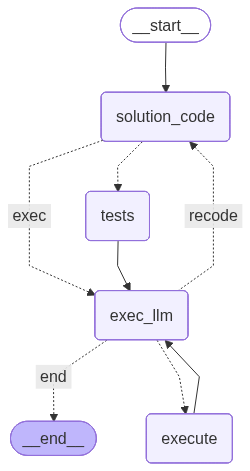

In [7]:
@tool
def execute_code_sub(code: str = Field(description="Code to be executed.")) -> str:
    """Executes the given Python code and returns the output or error message."""
    try:
        # Create a temporary file
        with tempfile.NamedTemporaryFile(mode='w', suffix='.py', delete=False) as f:
            f.write(code)
            temp_file = f.name
        
        # Execute the file
        result = subprocess.run(
            ['python', temp_file],
            capture_output=True,
            text=True,
            timeout=30
        )
        
        # Clean up
        os.unlink(temp_file)
        
        if result.returncode == 0:
            return "TEST_PASSED"
        else:
            return f"Error: {result.stderr.strip()}"
            
    except subprocess.TimeoutExpired:
        return "Error: Execution timed out"
    except Exception as e:
        return f"Error: {e}"


# MODEL
llm = ChatGoogleGenerativeAI(
    model=os.getenv("GOOGLE_API_MODEL"),
    temperature=0)

solution_code_model = llm.with_structured_output(SolutionCode)
test_code_model = llm.with_structured_output(TestCode)


# STATE
class ExecutionState(BaseModel):
    tests_generated: bool = Field(default=False, description="Flag indicating if tests have been generated.")
    test_code: TestCode = None
    test_run: bool = Field(default=False, description="Flag indicating if tests have been run.")
    test_passed: bool = Field(default=False, description="Flag indicating if tests have passed.")
    solution_code: SolutionCode = None
    messages: Annotated[list[AnyMessage], add_messages]
    remaining_steps: RemainingSteps = RemainingSteps()
    


# NODES
def generate_code_tests(state: ExecutionState) -> dict:
    system_message = """
    You are an expert Python programmer. Write tests that can be executed directly without needing function definitions. 
    Use print statements to show test results.
    """
    instruction_message = """
    Write python test code for the following python code. The tests should print "PASSED" if all tests pass or show the specific error if any fail.
    
    Code to test: {solution_code}
    """
    
    messages = [
        SystemMessage(content=system_message),
        HumanMessage(content=instruction_message.format(solution_code=state.solution_code.solution_code))
    ]
    
    response = test_code_model.invoke(messages)
    return {
        "test_code": response, 
        "tests_generated": True,
        "messages": [AIMessage(content=f"Generated test code: {response.test_code}")]
    }

def generate_solution_code(state: ExecutionState) -> dict:
    
    if not state.solution_code:
        response = solution_code_model.invoke(state.messages)
        return {"solution_code": response, "messages": [AIMessage(content=f"Generated solution code: {response.solution_code}")]}
    else:
        system_message = """
        You are an expert Python programmer. You will be provided with a task. Write a solution to the task using python. Maintain proper code structure and include comments where necessary.
        """
        instruction_message = """
        The solution code provided earlier did not pass the tests.Review and fix the solution code to ensure it passes all tests.
        
        Solution Code: {solution_code}  
        
        Execution Results: {results}
        
        Respond with the corrected solution code only.
        """
        messages = [
            SystemMessage(content=system_message),
            HumanMessage(content=instruction_message.format(
                solution_code=state.solution_code.solution_code,
                results=state.messages[-1].content,
            ))
        ]
        # print("Invoking ReCode")  # Debug print (commented)
        result = solution_code_model.invoke(messages)
        return {"test_run": False, "solution_code": result, "messages": [AIMessage(content=f"Generated solution code: {result.solution_code}")]}



def exec_llm(state: ExecutionState) -> dict:
    execution_llm = llm.bind_tools([execute_code_sub])
    
    # Build messages for the LLM
    system_message = """
    You are an expert Python code tester. Execute the test code and analyze the results.
    If tests pass, respond with "TEST_PASSED". If tests fail, respond with "TEST_FAILED" and the error details.
    """
    
    # Check if we have tool results to process
    tool_results = []
    # print("Messages in State: ", state.messages)  # Debug print (commented)
    # print(f"State messages -1: {state.messages[-1]}")  # Debug print (commented)
    #for msg in state.messages:
    #    print("Processing message: ", msg)  # Debug print
    #    if isinstance(msg, ToolMessage) and msg.content:
    #        tool_results.append(msg.content)
    if isinstance(state.messages[-1], ToolMessage) and state.messages[-1].content:
        tool_results.append(state.messages[-1].content)
    
    if tool_results:
        # We have execution results to analyze
        instruction_message = """
        Analyze these test execution results and determine if the tests passed or failed:
        
        Test Code: {test_code}
        
        Execution Results: {results}
        
        Respond with "TEST_PASSED" if all tests passed, or "TEST_FAILED" with error details if any tests failed.
        """
        messages = [
            SystemMessage(content=system_message),
            HumanMessage(content=instruction_message.format(
                test_code=state.test_code.test_code,
                results="\n".join(tool_results)
            ))
        ]
        result = execution_llm.invoke(messages)
        # print("Analysis LLM Result: ", result.content)  # Debug print (commented)
        return {"messages": [result], "test_run": True, "test_passed": "TEST_PASSED" in result.content}
    else:
        # First call - need to execute the tests
        instruction_message = """
        Execute this test code and return the results: {test_code}
        """
        messages = [
            SystemMessage(content=system_message),
            HumanMessage(content=instruction_message.format(test_code=state.test_code.test_code))
        ]
    
        result = execution_llm.invoke(messages)
        # print("Execution LLM Result: ", result)  # Debug print (commented)
        return {"messages": [result]}


def pass_fail(state: ExecutionState) -> str:
    # Look for PASSED/FAILED in recent messages
    #recent_messages = state.messages[-5:]  # Check last 5 messages
    #print(f"TEST Status ---------- {state.test_run}")  # Debug print
    if (state.test_run and state.test_passed) or state.remaining_steps  <= 4:
        #print(f"Tests Passed ? {state.test_passed}")  # Debug print (commented)
        return "end"
    elif not state.test_run:
        return "execute"
    else:
        return "recode"


def skip_if_tests_generated(state: ExecutionState) -> str:
    return "tests" if not state.tests_generated else "exec"


# GRAPH

graph = StateGraph(ExecutionState)
graph.add_node("solution_code", generate_solution_code)
graph.add_node("tests", generate_code_tests)
graph.add_node("exec_llm", exec_llm)
graph.add_node("execute", ToolNode(tools=[execute_code_sub]))

graph.add_edge(START, "solution_code")
graph.add_edge("tests", "exec_llm")
graph.add_edge("execute", "exec_llm")

# Modified conditional edges to properly handle the flow
graph.add_conditional_edges("exec_llm", pass_fail, path_map={ "end": END, "recode": "solution_code", "execute": "execute" })
graph.add_conditional_edges("solution_code", skip_if_tests_generated, path_map={ "tests": "tests", "exec": "exec_llm" })



mbpp_graph = graph.compile()

mbpp_graph



In [8]:
# INSTRUCTIONS
system_message = """
You are an expert Python programmer. You will be provided with a task. Write a solution to the task using python. Maintain proper code structure and include comments where necessary.
"""
instruction_message = """
Write a solution for the following python task : {task}

Use the following function name for the solution code : {function_name}
"""


## EXECUTION
messages = [    SystemMessage(content=system_message),
                HumanMessage(content=instruction_message.format(task=df['prompt'].iloc[0], function_name=df['function_name'])) ]

result = mbpp_graph.invoke({"messages": messages},{"recursion_limit": 20})

In [9]:
result['test_passed']

True

In [10]:
result['solution_code'].solution_code

'\ndef first_repeated_char(s):\n    seen = set()\n    for char in s:\n        if char in seen:\n            return char\n        seen.add(char)\n    return None\n'

In [18]:
result['test_code'].test_code

'def test_first_repeated_char():\n    assert first_repeated_char("abcabc") == "a"\n    assert first_repeated_char("abcdef") == None\n    assert first_repeated_char("aabbcc") == "a"\n    assert first_repeated_char("hello world") == "l"\n    assert first_repeated_char("") == None\n    assert first_repeated_char("a") == None\n    assert first_repeated_char("abacaba") == "a"\n\ntest_first_repeated_char()'

In [11]:
# create LangSmith client
ls_client = Client()

In [12]:
dataset_name = "CA2 Dataset 1"
#dataset = client.create_dataset(dataset_name)

In [13]:
datasets = ls_client.list_datasets(dataset_name="CA2 Dataset 1")
dataset = next(datasets)
dataset

Dataset(name='CA2 Dataset 1', description=None, data_type=<DataType.kv: 'kv'>, id=UUID('f4591a48-b71e-4718-becb-5c1d224cdfe3'), created_at=datetime.datetime(2025, 11, 24, 13, 19, 32, 844396, tzinfo=datetime.timezone.utc), modified_at=datetime.datetime(2025, 11, 24, 13, 19, 32, 844396, tzinfo=datetime.timezone.utc), example_count=20, session_count=14, last_session_start_time=datetime.datetime(2025, 11, 25, 13, 53, 55, 448525), inputs_schema=None, outputs_schema=None, transformations=None, metadata={'runtime': {'sdk': 'langsmith-py', 'library': 'langsmith', 'runtime': 'python', 'platform': 'Linux-6.14.0-36-generic-x86_64-with-glibc2.39', 'sdk_version': '0.4.35', 'runtime_version': '3.12.3', 'langchain_version': '0.3.27', 'py_implementation': 'CPython', 'langchain_core_version': '0.3.79'}})

In [25]:
examples = []
for idx, row in df.iterrows():
    example = {
        "inputs": {
            "task": row['prompt'],
            "task_id": row['task_id'],
            "function_name": row['function_name']
        },
        "outputs": {
            "ref_code": row['code'],
            "ref_test_list": row['test_list_extracted']
        }
    }
    examples.append(example)



In [26]:
examples

[{'inputs': {'task': 'Write a python function to find the first repeated character in a given string.',
   'task_id': 602,
   'function_name': 'first_repeated_char'},
  'outputs': {'ref_code': 'def first_repeated_char(str1):\n  for index,c in enumerate(str1):\n    if str1[:index+1].count(c) > 1:\n      return c',
   'ref_test_list': ['assert first_repeated_char("abcabc") == "a"',
    'assert first_repeated_char("abc") == None',
    'assert first_repeated_char("123123") == "1"']}},
 {'inputs': {'task': 'Write a function to get all lucid numbers smaller than or equal to a given integer.',
   'task_id': 603,
   'function_name': 'get_ludic'},
  'outputs': {'ref_code': 'def get_ludic(n):\n\tludics = []\n\tfor i in range(1, n + 1):\n\t\tludics.append(i)\n\tindex = 1\n\twhile(index != len(ludics)):\n\t\tfirst_ludic = ludics[index]\n\t\tremove_index = index + first_ludic\n\t\twhile(remove_index < len(ludics)):\n\t\t\tludics.remove(ludics[remove_index])\n\t\t\tremove_index = remove_index + firs

In [27]:

ls_client.create_examples(
    dataset_id=dataset.id,
    examples=examples
)

{'example_ids': ['15127668-6ba0-4a3f-9ac5-ecb21901d7d7',
  '1b1d17a0-e0c9-4859-a9d3-f46bcfd731c8',
  '47e3bf52-55fe-469d-bbb8-15f2035e8158',
  '77451c62-0185-4c9b-bbb6-3e7c6353a96b',
  '985e6244-afca-4a14-b742-86b74e90058c',
  'c44deda6-d405-448f-966e-ea8989842e05',
  'c29c4f3c-a033-4907-96a9-453fd81b247f',
  '6ab2e0b3-236c-4e31-9c66-064429218037',
  'ab243a24-369b-463e-a681-05fab9751654',
  '2ef564dd-5810-4a9b-9cb6-3e4b96d74b71',
  '66359c00-10a7-4645-aa97-eec19f62f5ce',
  'b2e93242-7f22-4479-9f41-a996b4eeb6cd',
  'dd80190b-e537-4cd5-b157-993d3a8760bb',
  '881e6322-8f85-4eb5-ad44-222a05d3ab00',
  'e0ebcd13-fe18-407c-924e-d9acad042e81',
  '4cdad7ab-26a3-474c-888d-3954b3db5fcd',
  'e2dad81f-304a-4794-9df5-9288e87bdc5e',
  'f02dbcc4-094b-4755-9edc-f5cda7534925',
  'f955c8ad-8f59-42c1-8e4d-2a1cf3fc4f1b',
  'cec15dcb-bded-41ac-b891-a62d76a389e2'],
 'count': 20}

In [28]:
def test_accuracy(outputs: dict, reference_outputs: dict) -> int:
    """Evaluate the solution code against the reference test code. Returns percentage of reference tests passed"""
    #print(f"Outputs keys: {outputs.keys()}")  # Debug
    #print(f"Reference outputs keys: {reference_outputs.keys()}")  # Debug
    #print(f"Reference outputs: {reference_outputs}")  # Debug
    resp_code = outputs['response']['solution_code'].solution_code
    ref_tests = reference_outputs['ref_test_list']
    total_tests = len(ref_tests)
    if total_tests == 0:
        return 100  # No tests to run, consider as 100% passed
    passed_tests = 0
    for test in ref_tests:
        """run code"""
        #result = execute_code_sub(code=resp_code + "\n" + test)
        result = execute_code_sub.invoke({"code": resp_code + "\n" + test})
        if "TEST_PASSED" in result:
            passed_tests += 1
    accuracy = (passed_tests / total_tests) * 100
    return accuracy

In [29]:
from time import sleep
def my_app(task: str, function_name: str):
    # INSTRUCTIONS
    system_message = """
    You are an expert Python programmer. You will be provided with a task. Write a solution to the task using python. Maintain proper code structure and include comments where necessary.
    """
    instruction_message = """
    Write a solution for the following python task : {task}

    Use the following function name for the solution code : {function_name}
    """


    ## EXECUTION
    messages = [    SystemMessage(content=system_message),
                HumanMessage(content=instruction_message.format(task=task, function_name=function_name)) ]

    result = mbpp_graph.invoke({"messages": messages},{"recursion_limit": 20})
    sleep(20)  # To help stop hitting the API quota
    return result

In [36]:
def ls_target(inputs: dict) -> dict:
    return {"response": my_app(inputs['task'], inputs['function_name'])}

In [31]:
ls_client.evaluate(
    ls_target,
    dataset_name,
    evaluators=[test_accuracy],
    experiment_prefix="ca2"
)

View the evaluation results for experiment: 'ca2-9a6fb7fa' at:
https://smith.langchain.com/o/964e7404-67a2-4b32-87f1-9ca489d8bbd5/datasets/f4591a48-b71e-4718-becb-5c1d224cdfe3/compare?selectedSessions=ab9d58dd-9e4c-41bc-8075-a87cad75b979




1it [00:41, 41.28s/it]Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15, model: gemini-2.5-flash-lite
Please retry in 53.632008615s. [links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash-lite"
  }
  quota_dimensions {
    key: "location"
    valu

,inputs.task,inputs.task_id,inputs.function_name,outputs.response,error,reference.ref_code,reference.ref_test_list,feedback.test_accuracy,execution_time,example_id,id
0,Write a function to move all the numbers to th...,619,move_num,"{'tests_generated': True, 'test_code': test_co...",None,def move_num(test_str):\n res = ''\n dig = '...,[assert move_num('I1love143you55three3000thous...,0.000000,41.222294,15127668-6ba0-4a3f-9ac5-ecb21901d7d7,da339273-b492-4035-9ca1-bc975e42daa9
1,Write a function to find the median of two sor...,622,get_median,"{'tests_generated': True, 'test_code': test_co...",None,"def get_median(arr1, arr2, n):\n i = 0\n j =...","[assert get_median([1, 12, 15, 26, 38], [2, 13...",0.000000,41.522763,1b1d17a0-e0c9-4859-a9d3-f46bcfd731c8,14a8b960-f2a2-4834-a908-5c19a64279ed
2,Write a python function to convert a given str...,624,is_upper,"{'tests_generated': True, 'test_code': test_co...",None,def is_upper(string):\n return (string.upper()),"[assert is_upper(""person"") ==""PERSON"", assert ...",100.000000,24.115835,2ef564dd-5810-4a9b-9cb6-3e4b96d74b71,beb0bac3-35c1-4800-9d96-673800d1517c
3,Write a python function which takes a list of ...,612,merge,"{'tests_generated': True, 'test_code': test_co...",None,def merge(lst): \n return [list(ele) for e...,"[assert merge([['x', 'y'], ['a', 'b'], ['m', '...",0.000000,43.166404,47e3bf52-55fe-469d-bbb8-15f2035e8158,f7f0c489-de7f-46af-9c51-a5abc4ede6a8
4,Write a python function to find the first repe...,602,first_repeated_char,"{'tests_generated': True, 'test_code': test_co...",None,"def first_repeated_char(str1):\n for index,c ...","[assert first_repeated_char(""abcabc"") == ""a"", ...",100.000000,26.092071,4cdad7ab-26a3-474c-888d-3954b3db5fcd,cd2fc4ed-edd9-4a02-ba7a-56592f784141
5,Write a function to reverse words seperated by...,604,reverse_words,"{'tests_generated': True, 'test_code': test_co...",None,def reverse_words(s):\n return ' '.join...,"[assert reverse_words(""python program"")==(""pro...",0.000000,25.193124,66359c00-10a7-4645-aa97-eec19f62f5ce,b9941e9f-85f6-4ada-8226-b4577e6d5b2c
6,Write a python function which takes a list and...,610,remove_kth_element,"{'tests_generated': True, 'test_code': test_co...",None,"def remove_kth_element(list1, L):\n return ...","[assert remove_kth_element([1,1,2,3,4,4,5,1],3...",33.333333,27.291880,6ab2e0b3-236c-4e31-9c66-064429218037,5800755a-1460-45e2-8268-daedb526c945
7,Write a function which takes a tuple of tuples...,615,average_tuple,"{'tests_generated': True, 'test_code': test_co...",None,def average_tuple(nums):\n result = [sum(x)...,"[assert average_tuple(((10, 10, 10, 12), (30, ...",0.000000,30.044620,77451c62-0185-4c9b-bbb6-3e7c6353a96b,a093bb96-5707-4c57-9449-cd38a0c623b8
8,Write a function to divide two lists element w...,618,div_list,"{'tests_generated': True, 'test_code': test_co...",None,"def div_list(nums1,nums2):\n result = map(lam...","[assert div_list([4,5,6],[1, 2, 3])==[4.0,2.5,...",100.000000,27.788237,881e6322-8f85-4eb5-ad44-222a05d3ab00,1082d64a-17f0-43eb-9073-1d366b867c9d
9,Write a function to find the size of the large...,620,largest_subset,"{'tests_generated': True, 'test_code': test_co...",None,def largest_subset(a):\n\tn = len(a)\n\tdp = [...,"[assert largest_subset([ 1, 3, 6, 13, 17, 18 ]...",100.000000,27.545915,985e6244-afca-4a14-b742-86b74e90058c,9822d5af-6ce8-4728-9d98-6bedfa23b191


In [32]:
# use SDK to wrap Gemini LLM
model = openai.Client( api_key=os.getenv("GEMINI_API_KEY"),
                        base_url=os.getenv("GEMINI_API_BASE"))
comparison_llm = wrappers.wrap_openai(model)

In [33]:
# Prompt to evaluate correctness
user_prompt = """"
You are grading the following python code:
{solution_code}
Against this reference code:
{ref_code}
The coding task was:
{task}
Provide a score from 1 to 5, where 5 is completely correct and 1 is completely incorrect:
Score:
Provide a brief explanation of the score:
Comment:

"""

eval_prompt = " You are an expert teacher in python developement, grading student answers to coding tasks."

In [34]:
# Use a structured output to ensure LLM returns a score.  Also returns a comment to provide explanation of score.
class CorrectnessEvalSchema(BaseModel):
    """Class to define the schema for correctness evaluation."""
    score: int = Field(description="An integer score from 1 to 5 indicating the correctness of the answer")
    comment: str = Field(description="A brief explanation of the score")

In [40]:
def q_correctness(inputs: dict,
                outputs: dict,
                reference_outputs: dict) -> int:
    """ Evaluate the correctness of the response using Gemini LLM with a structured output."""
    # extract response from outputs
    resp =  outputs['response']
    sleep(30)
    # call Gemini LLM with evaluation prompt
    response = comparison_llm.chat.completions.parse(
        model="gemini-2.5-flash-lite",
        messages = [{"role": "system", "content": eval_prompt},
                    {"role": "user", 
                     "content": user_prompt.format(task=inputs['task'],
                                                   solution_code=resp['solution_code'].solution_code,
                                                   ref_code=reference_outputs['ref_code'])}],
                temperature = 0,
                response_format=CorrectnessEvalSchema,
    )
    # extract score and comment from response
    result = response.choices[0].message.parsed
    print(f"Score: {result.score}, Comment: {result.comment}")
    # return score and comment as a dict. LangSmith expects a dict return type with these keys.
    # You can also return just an integer score or boolean if you prefer.
    return {"score": result.score, "comment": result.comment}


In [41]:
ls_client.evaluate(
    ls_target,
    dataset_name,
    evaluators=[q_correctness],
    experiment_prefix="ca2_1"
)

View the evaluation results for experiment: 'ca2_1-813f1ffb' at:
https://smith.langchain.com/o/964e7404-67a2-4b32-87f1-9ca489d8bbd5/datasets/f4591a48-b71e-4718-becb-5c1d224cdfe3/compare?selectedSessions=16bd3b4b-d3e4-40b7-90bc-badeefe7a0a0




1it [01:19, 79.68s/it]

Score: 5, Comment: The student's code is functionally identical to the reference code and correctly solves the problem. It iterates through the string, separating digits from non-digit characters, and then concatenates them with digits at the end. The variable names are clear and the logic is sound.


2it [02:21, 69.38s/it]

Score: 4, Comment: The student's code correctly calculates the median of two sorted lists of the same size. It merges the lists and then finds the median. The logic is sound and produces the correct output. However, the reference solution is more efficient as it avoids explicitly merging the entire lists, instead tracking the necessary elements to calculate the median. The student's code is a valid and understandable approach, but not the most optimal one.


3it [03:18, 63.49s/it]

Score: 5, Comment: The student's code is functionally identical to the reference code and correctly implements the task of converting a string to uppercase. The docstring is also well-written and informative.


4it [04:23, 64.19s/it]

Score: 3, Comment: The student's code works correctly for the given problem description. However, it is not as concise or Pythonic as the reference solution, which utilizes `zip` for a more elegant approach. The student's solution uses list comprehensions to explicitly extract the first and second elements, which is less efficient and harder to generalize if the sublists had more than two elements.


5it [05:20, 61.63s/it]

Score: 5, Comment: The student's code correctly identifies the first repeated character in a string using a set for efficient lookups. It handles cases with no repeated characters by returning None. The logic is sound and the implementation is clean and Pythonic. It is functionally equivalent to the reference solution, though it uses a different approach.


6it [06:18, 60.21s/it]

Score: 3, Comment: The student's code correctly reverses the words in the string. However, it does not handle multiple spaces between words as gracefully as the reference solution, which collapses them into single spaces. The student's approach would preserve multiple spaces, which might not be the desired behavior depending on the exact interpretation of 'words separated by spaces'.


7it [07:15, 59.39s/it]

Score: 2, Comment: The student's code attempts to remove the k'th element but has an off-by-one error in its indexing. The reference code uses `L-1` for the slice, implying a 1-based indexing for `L`, while the student's code uses `k` directly, suggesting 0-based indexing. The student's code also includes error handling for out-of-bounds `k`, which is good practice but not strictly required by the prompt and differs from the reference solution's approach.


8it [08:17, 60.00s/it]

Score: 2, Comment: The student's code correctly calculates the average for each inner tuple. However, it does not use the `zip(*nums)` approach demonstrated in the reference code, which is likely what the task intended to assess. The student's solution is functional but doesn't align with the expected pattern for this specific exercise.


9it [09:17, 60.16s/it]

Score: 3, Comment: The student's code correctly implements the element-wise division and handles the edge cases of lists with different lengths and division by zero. However, it does not use a more Pythonic approach like list comprehension or `map` as seen in the reference solution, and it prints error messages instead of raising exceptions, which is generally preferred for error handling in functions.


10it [10:16, 59.90s/it]

Score: 2, Comment: The student's code attempts to solve the problem using dynamic programming, which is a good approach. However, the logic for checking divisibility and updating the DP table is incorrect. The reference solution checks for divisibility in both directions (a[j] % a[i] == 0 or a[i] % a[j] == 0), while the student's code only checks one direction (nums[i] % nums[j] == 0). Additionally, the DP update logic in the student's code is not aligned with the problem's requirement of finding the largest subset where *every pair* is divisible. The reference solution correctly iterates backward and considers divisibility with subsequent elements. The student's code sorts the array first, which is not strictly necessary for the reference solution's logic and might lead to incorrect assumptions about divisibility relationships.


11it [11:19, 60.61s/it]

Score: 1, Comment: The student's code correctly calculates the number of jumps needed to reach a point on the x-axis. However, the reference code suggests a more complex problem involving two possible jump lengths (represented by 'steps'). The student's solution does not address this complexity and assumes a single, fixed jump length. Therefore, it does not fully meet the implied requirements of the problem as suggested by the reference solution.


12it [12:23, 61.70s/it]

Score: 3, Comment: The student's code correctly uses the `re` module to find a pattern in a string and returns the matching substring, start index, and end index. However, the reference code returns the pattern itself, not the matching substring. The student's implementation is more aligned with the task description of returning the 'matching substring'. The student's code is good, but it could be improved by handling the case where no match is found more explicitly, although the current return of (None, -1, -1) is a reasonable way to indicate no match.


13it [13:19, 59.87s/it]

Score: 5, Comment: The student's code is functionally identical to the reference code and correctly converts degrees to radians. The variable naming is clear and the logic is sound.


14it [14:14, 58.55s/it]

Score: 3, Comment: The student's code correctly identifies prime numbers for most cases. However, it has a slight inefficiency by iterating up to the square root of n, whereas the reference code iterates up to n//2. The reference code also has a logical error in its else block, which would cause it to return True prematurely for non-prime numbers. The student's code is more efficient and correct in its logic for primality testing.


15it [15:25, 62.38s/it]

Score: 4, Comment: The student's code is functionally correct and handles edge cases like differing tuple lengths and division by zero. However, it is less concise than the reference solution, which uses a generator expression and `zip` for a more Pythonic approach. The student's code is more verbose than necessary.


16it [16:24, 61.38s/it]

Score: 3, Comment: The student's code correctly calculates the cumulative sum of values in a list of tuples. However, it uses a nested loop approach, which is less efficient and less Pythonic than the reference solution that utilizes `sum` and `map`. The variable naming could also be improved for clarity.


17it [17:24, 60.92s/it]

Score: 5, Comment: The student's code is functionally identical to the reference solution and correctly implements the required functionality. It uses a list comprehension, which is a Pythonic and efficient way to achieve the result. The type hints are a good addition.


18it [18:24, 60.70s/it]

Score: 2, Comment: The student's code attempts to implement the Sieve of Eratosthenes for Ludic numbers but has a logical error in how it removes multiples. It incorrectly removes numbers based on the current Ludic number itself rather than its position in the list. The reference code uses a different approach that directly manipulates indices for removal, which is more efficient and correct for this specific problem. The student's code will not produce the correct sequence of Ludic numbers.


19it [19:40, 65.15s/it]

Score: 2, Comment: The student's code has a minor error in the inner loop calculation. It should be `bell[i][j] = bell[i-1][j-1] + bell[i][j-1]` instead of `bell[i][j] = bell[i][j - 1] + bell[i - 1][j - 1]`. This will lead to incorrect Bell numbers for n > 1.


20it [20:43, 64.58s/it]

Score: 4, Comment: The student's code correctly implements the logic to find the maximum value in the n'th column of a matrix. It handles edge cases like an empty matrix or an invalid column index. The code is well-commented and readable. The only minor difference from the reference solution is the use of a loop instead of a list comprehension, which is a stylistic choice and doesn't affect correctness or efficiency significantly for typical inputs. The reference solution is more concise but might be less readable for beginners and doesn't explicitly handle edge cases like an empty matrix or out-of-bounds column index as robustly as the student's code.


20it [20:44, 62.21s/it]


,inputs.task,inputs.task_id,inputs.function_name,outputs.response,error,reference.ref_code,reference.ref_test_list,feedback.q_correctness,execution_time,example_id,id
0,Write a function to move all the numbers to th...,619,move_num,"{'tests_generated': True, 'test_code': test_co...",None,def move_num(test_str):\n res = ''\n dig = '...,[assert move_num('I1love143you55three3000thous...,5,40.466395,15127668-6ba0-4a3f-9ac5-ecb21901d7d7,1c4fae33-69e8-49ae-a9e8-724a298dfb25
1,Write a function to find the median of two sor...,622,get_median,"{'tests_generated': True, 'test_code': test_co...",None,"def get_median(arr1, arr2, n):\n i = 0\n j =...","[assert get_median([1, 12, 15, 26, 38], [2, 13...",4,30.682206,1b1d17a0-e0c9-4859-a9d3-f46bcfd731c8,0e0ecaf9-89f1-42a4-a8a2-ebdfcccf1371
2,Write a python function to convert a given str...,624,is_upper,"{'tests_generated': True, 'test_code': test_co...",None,def is_upper(string):\n return (string.upper()),"[assert is_upper(""person"") ==""PERSON"", assert ...",5,24.643139,2ef564dd-5810-4a9b-9cb6-3e4b96d74b71,a7a291fa-e771-417d-8a0d-e5cbc284dd27
3,Write a python function which takes a list of ...,612,merge,"{'tests_generated': True, 'test_code': test_co...",None,def merge(lst): \n return [list(ele) for e...,"[assert merge([['x', 'y'], ['a', 'b'], ['m', '...",3,34.433629,47e3bf52-55fe-469d-bbb8-15f2035e8158,a390cfd9-c4ed-47ed-9eb4-b28221da9d7e
4,Write a python function to find the first repe...,602,first_repeated_char,"{'tests_generated': True, 'test_code': test_co...",None,"def first_repeated_char(str1):\n for index,c ...","[assert first_repeated_char(""abcabc"") == ""a"", ...",5,25.994460,4cdad7ab-26a3-474c-888d-3954b3db5fcd,ba5631ec-ba1c-48f3-82d4-0b9175a5450c
5,Write a function to reverse words seperated by...,604,reverse_words,"{'tests_generated': True, 'test_code': test_co...",None,def reverse_words(s):\n return ' '.join...,"[assert reverse_words(""python program"")==(""pro...",3,26.638604,66359c00-10a7-4645-aa97-eec19f62f5ce,ced8755f-ada5-4f80-9d0a-e454ec54eff8
6,Write a python function which takes a list and...,610,remove_kth_element,"{'tests_generated': True, 'test_code': test_co...",None,"def remove_kth_element(list1, L):\n return ...","[assert remove_kth_element([1,1,2,3,4,4,5,1],3...",2,26.715411,6ab2e0b3-236c-4e31-9c66-064429218037,2baf6dd3-8110-401b-9b40-ed1348c4dfb0
7,Write a function which takes a tuple of tuples...,615,average_tuple,"{'tests_generated': True, 'test_code': test_co...",None,def average_tuple(nums):\n result = [sum(x)...,"[assert average_tuple(((10, 10, 10, 12), (30, ...",2,30.105780,77451c62-0185-4c9b-bbb6-3e7c6353a96b,29ad0eb8-8ebb-46e8-8b12-5c1aaf47d9fb
8,Write a function to divide two lists element w...,618,div_list,"{'tests_generated': True, 'test_code': test_co...",None,"def div_list(nums1,nums2):\n result = map(lam...","[assert div_list([4,5,6],[1, 2, 3])==[4.0,2.5,...",3,29.426812,881e6322-8f85-4eb5-ad44-222a05d3ab00,7db69d8a-4a1a-4647-87f1-1911955e4090
9,Write a function to find the size of the large...,620,largest_subset,"{'tests_generated': True, 'test_code': test_co...",None,def largest_subset(a):\n\tn = len(a)\n\tdp = [...,"[assert largest_subset([ 1, 3, 6, 13, 17, 18 ]...",2,27.781576,985e6244-afca-4a14-b742-86b74e90058c,f38d1a05-14df-4eea-9f8c-0d4a1e3e3cb9
